# Fake News Classifier

11.11.2020. 
Filip Sosa

Učitavanje osnovnih biblioteka

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import seaborn as sn

## Analiza podataka

In [4]:
#Učitavanje podataka
news_df = pd.read_csv('train.csv')
news_df.head(10)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


In [5]:
#Provjera postoje li NaN vrijednosti te zamjena istih praznim stringom
print(news_df.isna().sum())
news_df = news_df.fillna(' ')

#Uklanjanje duplikata ukoliko postoje
news_df = news_df.drop_duplicates(subset=['text'], keep='first')

id           0
title      558
author    1957
text        39
label        0
dtype: int64


In [6]:
#Spajanje naslova, autora i teksta novinskog članka
x_train = news_df['title'] + ' ' + news_df['author'] + ' ' + news_df['text']
y_train = news_df['label']

#Učitavanje testnih podataka
news_df_test = pd.read_csv('test.csv')
news_df_test = news_df_test.fillna(' ')
x_test = news_df_test['title'] + ' ' + news_df_test['author'] + ' ' + news_df_test['text']
y_test = pd.read_csv('submit.csv')['label']

print(x_train.shape)
print(x_test.shape)


(20386,)
(5200,)


In [7]:
#Provjera uravnoteženosti klasa
N = len(news_df)
percentage_real_news = len(news_df['label'][news_df['label'] == 0]) * 100 / N
percentage_fake_news = len(news_df['label'][news_df['label'] == 1]) * 100 / N

print('Postotak primjer klasificiranih kao real news je ' + str(round(percentage_real_news, 2)) + '%')
print('Postotak primjer klasificiranih kao fake news je ' + str(round(percentage_fake_news, 2)) + '%')

if abs(percentage_real_news - percentage_fake_news) < 20:
    print('Klase su uravnotežene')
else:
    print('Klase nisu uravnotežene')

Postotak primjer klasificiranih kao real news je 50.95%
Postotak primjer klasificiranih kao fake news je 49.05%
Klase su uravnotežene


**Zaključak:**
U podatcima se nalazi približno jednak broj real i fake news članaka što je dobro obilježje za klasifikaciju.

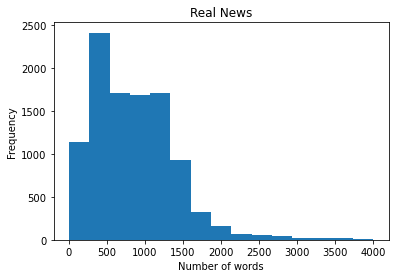

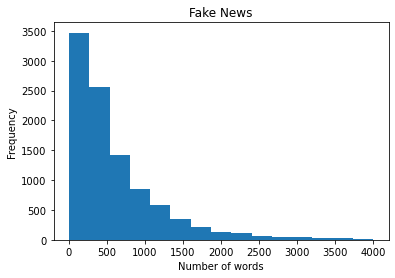

Real news
Srednja vrijednost ukupnog broja riječi u članku je 895.3430249350149, dok je medijan jednak 790.0
Fake news
Srednja vrijednost ukupnog broja riječi u članku je 661.5962596259626, dok je medijan jednak 407.0


In [8]:
#Usporedba broja riječi kod fake i real news članaka 
x_total_len_real = [len(x.split()) for x in x_train[news_df['label'] == 0]]
x_total_len_fake = [len(x.split()) for x in x_train[news_df['label'] == 1]]

plt.hist(x_total_len_real, bins=15, range=[0, 4001])
plt.title('Real News')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()
plt.hist(x_total_len_fake, bins=15, range=[0, 4001])
plt.title('Fake News')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()

print('Real news')
print('Srednja vrijednost ukupnog broja riječi u članku je ' + str(np.mean(x_total_len_real)) + ', dok je medijan jednak ' + str(np.median(x_total_len_real)))
print('Fake news')
print('Srednja vrijednost ukupnog broja riječi u članku je ' + str(np.mean(x_total_len_fake)) + ', dok je medijan jednak ' + str(np.median(x_total_len_fake)))

**Zaključak:**
Iz histograma i medijana ukupnog broja riječi u članku može se zaključiti da real news članci imaju više riječi od fake news članaka.

## Izrada modela

In [9]:
#Postavljanje hiperparametara modela
padding = 'post'
oov_token = '<OOV>'
truncating = 'post'

vocabulary_size = 200
max_length = 100
embedding_dim = 40

In [10]:
#Tokenizacija
tokenizer = Tokenizer(num_words = vocabulary_size, oov_token = oov_token)
tokenizer.fit_on_texts(x_train)

x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_train_padded = pad_sequences(x_train_sequences, maxlen = max_length, padding = padding, truncating = truncating)

x_test_sequences = tokenizer.texts_to_sequences(x_test)
x_test_padded = pad_sequences(x_test_sequences, maxlen = max_length, padding = padding, truncating = truncating)

### Treniranje 4 modela:
<br>
1. Logistička regresija 
<br>
2. Bayesov klasifikator
<br>
3. Stabla odluke
<br>
4. Neuronska mreža

In [11]:
#Pomoćne funkcije za prikaz rezultata i matrice konfuzije
def plot_confusion_matrix(cnf_matrix, classes):
    plt.figure()
    sn.heatmap(cnf_matrix, annot = True)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks + 0.5, classes, rotation=0)
    plt.yticks(tick_marks + 0.2, classes)
    
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()

def results_info(y_pred, y_test):
    print('Uspješnost modela:')
    print(classification_report(y_pred, y_test))
    cnf_matrix = confusion_matrix(y_test, y_pred)
    print('Matrica konfuzije:')
    print(cnf_matrix)
    plot_confusion_matrix(cnf_matrix, classes=['Real news','Fake news'])

**1. Logistička regresija**

Uspješnost modela:
              precision    recall  f1-score   support

           0       0.64      0.60      0.62      2464
           1       0.66      0.69      0.67      2736

    accuracy                           0.65      5200
   macro avg       0.65      0.65      0.65      5200
weighted avg       0.65      0.65      0.65      5200

Matrica konfuzije:
[[1488  851]
 [ 976 1885]]


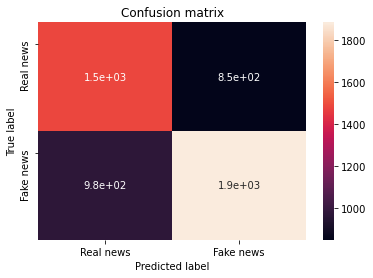

In [12]:
from sklearn.linear_model import LogisticRegression

#Logistička regresija
log_reg_model = LogisticRegression()
log_reg_model.fit(x_train_padded, y_train)
y_pred = log_reg_model.predict(x_test_padded)

#Prikaz rezultata
results_info(y_pred, y_test)

**2. Bayesov klasifikator**

Uspješnost modela:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2166
           1       1.00      0.94      0.97      3034

    accuracy                           0.96      5200
   macro avg       0.96      0.97      0.96      5200
weighted avg       0.97      0.96      0.96      5200

Matrica konfuzije:
[[2157  182]
 [   9 2852]]


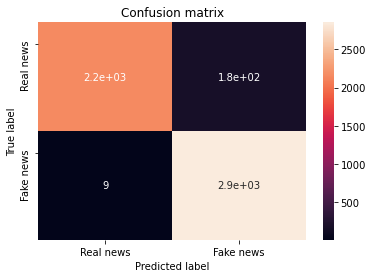

In [55]:
from sklearn.naive_bayes import MultinomialNB

NB_model = MultinomialNB()
NB_model.fit(x_train_padded, y_train)
y_pred = NB_model.predict(x_test_padded)

#Prikaz rezultata
results_info(y_pred, y_test)

**3. Stabla odluke**

Uspješnost modela:
              precision    recall  f1-score   support

           0       0.76      0.67      0.71      2633
           1       0.70      0.78      0.74      2567

    accuracy                           0.73      5200
   macro avg       0.73      0.73      0.73      5200
weighted avg       0.73      0.73      0.73      5200

Matrica konfuzije:
[[1774  565]
 [ 859 2002]]


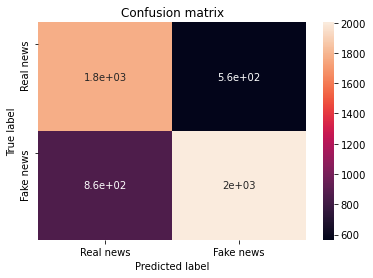

In [63]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion="entropy", max_depth = 3)
tree_model.fit(x_train_padded, y_train)
y_pred = tree_model.predict(x_test_padded)

#Prikaz rezultata
results_info(y_pred, y_test)

**4. Neuronska mreža**

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocabulary_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 40)           8000      
_________________________________________________________________
global_average_pooling1d (Gl (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                984       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 9,009
Trainable params: 9,009
Non-trainable params: 0
_________________________________________________________________


In [14]:
num_epochs = 10
history = model.fit(x_train_padded, y_train, epochs=num_epochs, batch_size=64, validation_data=(x_test_padded, y_test), verbose=1)

Epoch 1/10
319/319 [==============================] - 1s 2ms/step - loss: 0.5124 - accuracy: 0.7799 - val_loss: 0.7484 - val_accuracy: 0.6558
Epoch 2/10
319/319 [==============================] - 0s 2ms/step - loss: 0.2761 - accuracy: 0.8854 - val_loss: 1.0116 - val_accuracy: 0.6477
Epoch 3/10
319/319 [==============================] - 1s 2ms/step - loss: 0.2469 - accuracy: 0.8970 - val_loss: 1.1108 - val_accuracy: 0.6388
Epoch 4/10
319/319 [==============================] - 0s 2ms/step - loss: 0.2396 - accuracy: 0.9012 - val_loss: 1.1122 - val_accuracy: 0.6588
Epoch 5/10
319/319 [==============================] - 1s 2ms/step - loss: 0.2367 - accuracy: 0.9014 - val_loss: 1.1526 - val_accuracy: 0.6377
Epoch 6/10
319/319 [==============================] - 1s 2ms/step - loss: 0.2346 - accuracy: 0.9025 - val_loss: 1.1296 - val_accuracy: 0.6500
Epoch 7/10
319/319 [==============================] - 1s 2ms/step - loss: 0.2333 - accuracy: 0.9041 - val_loss: 1.1313 - val_accuracy: 0.6485
Epoch 

**Zaključak:**
Bayesov klasifikator dao je najbolje rezultate s točnošću od 96%. Nešto lošije rezultate dali su ostali modeli.